## Unique Conditions Modelling
This code will investigate the number of unique conditions a pet can have using a number of neural network techniques. 

Source code inspired by https://laub.au/DeepLearningForActuaries/.

## 1. Imports
Importing necessary packages.

In [170]:
# Import libraries
import os
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## 2. Data Import and Investigation
Importing compiled and cleaned data.

In [171]:
# Set working directory
os.chdir(r"C:\Users\ameli\OneDrive - UNSW\2024 Trimester 3\ACTL 4305 Actuarial Data Analytic Applications\Assignment")

# Import cleaned csv file
clean_data = pd.read_csv("actl4305_data_v88.csv")

# Import cleaned sample policyholders file
sample_data = pd.read_csv("unseen_df.csv")

In [172]:
# Investigate dataset
clean_data.head()

,Unnamed: 0,nb_postcode,X,UW_Date,exposure_id,tenure.x,pet_gender,pet_de_sexed,pet_de_sexed_age,pet_is_switcher,...,agricultural_land,national_parks_band,agricultural_land_band,electoraterating_remap,electoraterating_BAND,breed_type_band,breed_severity_band,national_parks_sev_band,median_income_band_sev,electoraterating_grouped
0,1,810,9088,1/04/2024,exposure_d2dfb08e-e29b-4f00-9452-0b3f4473ec28,2,male,True,Not Sure,Unknown,...,0.0,0,0,All Else,All Else,all_else,Unknown,0-5%,6-Jul,Inner/Unknown
1,2,810,1669,1/01/2024,exposure_0625abbb-ccf4-4d37-95ed-55dcbfc39eed,2,male,False,NaN,Unknown,...,0.0,0,0,All Else,All Else,purebred,Unknown,0-5%,6-Jul,Inner/Unknown
2,3,810,7060,1/03/2024,exposure_40b95a08-f57a-422d-8165-6d8d48553a02,4,male,False,NaN,Unknown,...,0.0,0,0,All Else,All Else,all_else,Unknown,0-5%,6-Jul,Inner/Unknown
3,4,810,35016,1/08/2024,exposure_0c3d059f-8b23-4d23-858c-20c2ac0fd871,3,female,False,NaN,Unknown,...,0.0,0,0,All Else,All Else,all_else,Unknown,0-5%,6-Jul,Inner/Unknown
4,5,810,13524,1/05/2024,exposure_40b95a08-f57a-422d-8165-6d8d48553a02,6,male,False,NaN,Unknown,...,0.0,0,0,All Else,All Else,all_else,Unknown,0-5%,6-Jul,Inner/Unknown


In [173]:
sample_data.head()

,Unnamed: 0,nb_postcode,exposure_id,pet_gender,pet_de_sexed,pet_de_sexed_age,pet_is_switcher,pet_age_months,nb_contribution,nb_excess,...,nb_average_breed_size_FACTOR,binned_breeds,nb_contribution_FACTOR,nb_excess_FACTOR,electoraterating_grouped,breed_type_band,claim_preds,breed_severity_band,national_parks_sev_band,median_income_band_sev
0,1,810,exposure_9d3ffbf9-9ee9-4b17-bb21-05d94d8adec2,male,False,NaN,FALSE,5,90,100,...,2-Mar,1,90,100,Inner/Unknown,purebred,0.177595,High Severity,0-5%,6-Jul
1,2,810,exposure_0625abbb-ccf4-4d37-95ed-55dcbfc39eed,male,False,NaN,Unknown,3,80,0,...,2-Mar,1,80,0,Inner/Unknown,purebred,0.227971,Unknown,0-5%,6-Jul
2,3,810,exposure_5587ecbf-7f25-4b84-87a6-6eb567d99e7e,male,True,7-12 months,FALSE,30,80,200,...,2-Mar,2+,80,200,Inner/Unknown,all_else,0.025166,Moderate Severity,0-5%,6-Jul
3,4,810,exposure_50f61c00-0524-445c-9d21-8db0047aba27,male,False,NaN,FALSE,15,80,200,...,1,1,80,200,Inner/Unknown,purebred,0.016295,Moderate Severity,0-5%,6-Jul
4,5,810,exposure_d2dfb08e-e29b-4f00-9452-0b3f4473ec28,male,True,Not Sure,Unknown,13,80,0,...,1-Feb,1,80,0,Inner/Unknown,all_else,0.085378,Unknown,0-5%,6-Jul


Note to view some of the next few as scrollable elements.

In [174]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40491 entries, 0 to 40490
Data columns (total 99 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                40491 non-null  int64  
 1   nb_postcode                               40491 non-null  int64  
 2   X                                         40491 non-null  int64  
 3   UW_Date                                   40491 non-null  object 
 4   exposure_id                               40491 non-null  object 
 5   tenure.x                                  40491 non-null  int64  
 6   pet_gender                                40491 non-null  object 
 7   pet_de_sexed                              40491 non-null  bool   
 8   pet_de_sexed_age                          8674 non-null   object 
 9   pet_is_switcher                           40491 non-null  object 
 10  nb_policy_first_inception_date    

In [175]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 80 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                9876 non-null   int64  
 1   nb_postcode                               9876 non-null   int64  
 2   exposure_id                               9876 non-null   object 
 3   pet_gender                                9876 non-null   object 
 4   pet_de_sexed                              9876 non-null   bool   
 5   pet_de_sexed_age                          2379 non-null   object 
 6   pet_is_switcher                           9876 non-null   object 
 7   pet_age_months                            9876 non-null   int64  
 8   nb_contribution                           9876 non-null   int64  
 9   nb_excess                                 9876 non-null   int64  
 10  nb_address_type_adj                 

In [176]:
# Investigate ranges of variables
for i in clean_data.columns:
    print(i)
    print(clean_data[i].value_counts().sort_index(ascending = True))

Unnamed: 0
Unnamed: 0
1        1
2        1
3        1
4        1
5        1
        ..
40487    1
40488    1
40489    1
40490    1
40491    1
Name: count, Length: 40491, dtype: int64
nb_postcode
nb_postcode
810     52
812      9
820      3
830      8
832     13
        ..
7307     1
7310     7
7315     7
7316     8
7470     2
Name: count, Length: 1350, dtype: int64
X
X
2        1
3        1
4        1
5        1
6        1
        ..
41597    1
41598    1
41599    1
41600    1
41601    1
Name: count, Length: 40491, dtype: int64
UW_Date
UW_Date
1/01/2024    1936
1/02/2024    2666
1/03/2024    3443
1/04/2024    4374
1/05/2024    5359
1/06/2024    6337
1/07/2024    7563
1/08/2024    8813
Name: count, dtype: int64
exposure_id
exposure_id
exposure_000a0128-7995-4e26-91e2-fda217a5837d    4
exposure_000e4bc1-8623-43a5-a47f-3685d8d084be    2
exposure_000f48d8-d205-4ea8-839d-cceadde43de8    3
exposure_0014590f-b9e6-4122-9dc3-2e16003a5bd7    8
exposure_0015ad7c-fe8d-46fe-88a5-f15505d770cd    1


In [177]:
# Investigate ranges of variables
for i in sample_data.columns:
    print(i)
    print(sample_data[i].value_counts().sort_index(ascending = True))

Unnamed: 0
Unnamed: 0
1       1
2       1
3       1
4       1
5       1
       ..
9947    1
9948    1
9949    1
9950    1
9951    1
Name: count, Length: 9876, dtype: int64
nb_postcode
nb_postcode
810     11
812      2
820      1
830      2
832      3
        ..
7310     1
7315     2
7316     2
7330     2
7470     1
Name: count, Length: 1383, dtype: int64
exposure_id
exposure_id
exposure_000a0128-7995-4e26-91e2-fda217a5837d    1
exposure_000e4bc1-8623-43a5-a47f-3685d8d084be    1
exposure_000f48d8-d205-4ea8-839d-cceadde43de8    1
exposure_0015ad7c-fe8d-46fe-88a5-f15505d770cd    1
exposure_001bda28-243e-43d4-b062-4ca72a0471b2    1
                                                ..
exposure_ffd78146-8b16-4e19-a08c-23e8cf654afb    1
exposure_ffddd3b6-2a3c-4e43-86bf-97c12d02c239    1
exposure_ffe25e6d-0e3d-4862-8d8e-6702270e03c9    1
exposure_ffe53208-f2f3-45d5-88cc-a51446319217    1
exposure_ffea43a0-1395-4e36-8128-8fafb3fddc03    1
Name: count, Length: 9876, dtype: int64
pet_gender
pet_gen

#### Cleaned Data for Model Training
Going to take a smaller sample of the dataset for analysis right now, based on a range of variables that might be most important. The initial list has been inpired by the predictors used for frequency.

This means I will take:
- pet_gender (binary)
- pet_de_sexed (binary)
- pet_de_sexed_age (categorical ordinal - need to specify order)
- pet_age_months (numerical continuous)
- nb_contribution (categorical ordinal)
- nb_excess (categorical ordinal)
- nb_address_type_adj (binary)
- owner_age_years (numerical continuous)
- nb_number_of_breeds (categorical ordinal)
- nb_average_breed_size (numerical continuous)
- nb_breed_type (categorical nominal)
- is_multi_pet_plan (binary)
- num_unique_conditions (TARGET - categorical ordinal)
- median_taxable_income (numerical continuous)
- avg_weighted_Total_fully_engaged_percent (numerical continuous)
- avg_weighted_Completed_year12 (numerical continuous)
- avg_weighted_Unemployment_rate (numerical continuous)
- electoraterating (categorical ordinal - need to specify)
- RA_2021_NAME (categorical ordinal - need to specify)
- national_parks (numerical continuous)
- agricultural_land (numerical continuous)
- breed_type_band (binary)

Not using multilple claims - too close to target. I've also stayed away from the banded variables and used continuous data where possible, in case banding has removed some nuance. 

In [178]:
# Create smaller dataframe
key_data = clean_data[["pet_gender", "pet_de_sexed", "pet_de_sexed_age", "pet_age_months", 
                       "nb_contribution", "nb_excess", "nb_address_type_adj", "owner_age_years",
                       "nb_number_of_breeds", "nb_average_breed_size", "nb_breed_type",
                       "is_multi_pet_plan", "num_unique_conditions", "median_taxable_income",
                       "avg_weighted_Total_fully_engaged_percent", "avg_weighted_Completed_year12",
                       "avg_weighted_Unemployment_rate", "electoraterating", "RA_2021_NAME",
                       "national_parks", "agricultural_land", "breed_type_band"]]

In [179]:
# Understand the values these limited variables take on
for i in key_data.columns:
    print(i)
    print(key_data[i].value_counts().sort_index(ascending = True))

pet_gender
pet_gender
female    18289
male      22202
Name: count, dtype: int64
pet_de_sexed
pet_de_sexed
False    28052
True     12439
Name: count, dtype: int64
pet_de_sexed_age
pet_de_sexed_age
0-3 months     1442
1-2 yr         2145
2+ years        681
7-12 months    3808
Not Sure        598
Name: count, dtype: int64
pet_age_months
pet_age_months
1       282
2      6188
3      5692
4      2805
5      1544
       ... 
115       3
116       8
118       1
119      11
120       9
Name: count, Length: 118, dtype: int64
nb_contribution
nb_contribution
80     27022
90      8166
100     5303
Name: count, dtype: int64
nb_excess
nb_excess
0       6098
100    26189
200     8204
Name: count, dtype: int64
nb_address_type_adj
nb_address_type_adj
Apartment     5181
House        35310
Name: count, dtype: int64
owner_age_years
owner_age_years
18.0     93
19.0    218
20.0    393
21.0    399
22.0    673
       ... 
82.0     20
83.0     12
84.0      8
86.0      5
95.0      8
Name: count, Length: 69, dt

In [180]:
# Understand the missing values
print(key_data.isna().sum())


pet_gender                                      0
pet_de_sexed                                    0
pet_de_sexed_age                            31817
pet_age_months                                  0
nb_contribution                                 0
nb_excess                                       0
nb_address_type_adj                             0
owner_age_years                                73
nb_number_of_breeds                             0
nb_average_breed_size                           0
nb_breed_type                                   0
is_multi_pet_plan                               0
num_unique_conditions                           0
median_taxable_income                           0
avg_weighted_Total_fully_engaged_percent      205
avg_weighted_Completed_year12                 205
avg_weighted_Unemployment_rate                205
electoraterating                                0
RA_2021_NAME                                    0
national_parks                                  0


##### A few notes on data quality:
The pet_de_sexed_age variable seems to have many missing values which should surely be coded as "Not Sure". When pre-processing, this needs to be considered as an ordinal, categorical variable - struggling with how to reconcile this with the "Not Sure" category, will likely add in as the first or last category. The high number of NA values may lessen the value of this variable. 

Owner age years missing values seem to be low, happy to have that imputed with the mean during pre-processing. 

Three of the socioeconomic indicators have around 200 missing data points (Fully Engaged, Completed Year 12, Unemployment Rate). As with owner age, happy for these to also be imputed with mean. 


##### Pet_De_Sexed_Age
Data cleaning this specific variable as mentioned above.

In [181]:
# Allocate the missing values to the "Not Sure" category
key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].fillna("Not Sure")

C:\Users\ameli\AppData\Local\Temp\ipykernel_36184\2442574469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_data["pet_de_sexed_age"] = key_data["pet_de_sexed_age"].fillna("Not Sure")


In [182]:
# Confirm the categories are aligned now and there are no missing values
print(key_data["pet_de_sexed_age"].value_counts().sort_index(ascending = True))
print(key_data["pet_de_sexed_age"].isna().sum())

pet_de_sexed_age
0-3 months      1442
1-2 yr          2145
2+ years         681
7-12 months     3808
Not Sure       32415
Name: count, dtype: int64
0


#### Cleaned Sample Data 
Cleaning the sample data in a similar manner to enable premium predictions. Taking the same variables as I did from the training data set. 

This means I will take:
- pet_gender (binary)
- pet_de_sexed (binary)
- pet_de_sexed_age (categorical ordinal - need to specify order)
- pet_age_months (numerical continuous)
- nb_contribution (categorical ordinal)
- nb_excess (categorical ordinal)
- nb_address_type_adj (binary)
- owner_age_years (numerical continuous)
- nb_number_of_breeds (categorical ordinal)
- nb_average_breed_size (numerical continuous)
- nb_breed_type (categorical nominal)
- is_multi_pet_plan (binary)
- median_taxable_income (numerical continuous)
- avg_weighted_Total_fully_engaged_percent (numerical continuous)
- avg_weighted_Completed_year12 (numerical continuous)
- avg_weighted_Unemployment_rate (numerical continuous)
- electoraterating (categorical ordinal - need to specify)
- RA_2021_NAME (categorical ordinal - need to specify)
- national_parks (numerical continuous)
- agricultural_land (numerical continuous)
- breed_type_band (binary)

num_unique_conditions will clearly not be included in the features this time as it doesn't exist. 

In [183]:
# Create smaller dataframe
key_sample_data = sample_data[["pet_gender", "pet_de_sexed", "pet_de_sexed_age", "pet_age_months", 
                              "nb_contribution", "nb_excess", "nb_address_type_adj", "owner_age_years",
                              "nb_number_of_breeds", "nb_average_breed_size", "nb_breed_type",
                              "is_multi_pet_plan", "median_taxable_income",
                              "avg_weighted_Total_fully_engaged_percent", "avg_weighted_Completed_year12",
                              "avg_weighted_Unemployment_rate", "electoraterating", "RA_2021_NAME",
                              "national_parks", "agricultural_land", "breed_type_band"]]

In [184]:
# Understand the values these limited variables take on
for i in key_sample_data.columns:
    print(i)
    print(key_sample_data[i].value_counts().sort_index(ascending = True))

pet_gender
pet_gender
female    4496
male      5380
Name: count, dtype: int64
pet_de_sexed
pet_de_sexed
False    6520
True     3356
Name: count, dtype: int64
pet_de_sexed_age
pet_de_sexed_age
0-3 months      378
1-2 yr          584
2+ years        205
7-12 months    1024
Not Sure        188
Name: count, dtype: int64
pet_age_months
pet_age_months
1        87
2      1391
3      1305
4       665
5       352
       ... 
115       1
116       2
118       1
119       3
120       4
Name: count, Length: 119, dtype: int64
nb_contribution
nb_contribution
80     6893
90     2071
100     912
Name: count, dtype: int64
nb_excess
nb_excess
0      1051
100    4610
200    4215
Name: count, dtype: int64
nb_address_type_adj
nb_address_type_adj
Apartment    1321
House        8555
Name: count, dtype: int64
owner_age_years
owner_age_years
18.0     21
19.0     52
20.0     86
21.0     89
22.0    159
       ... 
82.0      6
83.0      3
84.0      1
86.0      2
95.0      1
Name: count, Length: 69, dtype: int64
n

In [185]:
# Understand the missing values
print(key_sample_data.isna().sum())

pet_gender                                     0
pet_de_sexed                                   0
pet_de_sexed_age                            7497
pet_age_months                                 0
nb_contribution                                0
nb_excess                                      0
nb_address_type_adj                            0
owner_age_years                               11
nb_number_of_breeds                            0
nb_average_breed_size                          0
nb_breed_type                                  0
is_multi_pet_plan                              0
median_taxable_income                          0
avg_weighted_Total_fully_engaged_percent      45
avg_weighted_Completed_year12                 45
avg_weighted_Unemployment_rate                45
electoraterating                               0
RA_2021_NAME                                   0
national_parks                                 0
agricultural_land                              0
breed_type_band     

Will data clean these few missing values in the method mentioned above.

In [186]:
# Allocate the missing values to the "Not Sure" category
key_sample_data["pet_de_sexed_age"] = key_sample_data["pet_de_sexed_age"].fillna("Not Sure")

C:\Users\ameli\AppData\Local\Temp\ipykernel_36184\2103259690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_sample_data["pet_de_sexed_age"] = key_sample_data["pet_de_sexed_age"].fillna("Not Sure")


In [187]:
# Confirm the categories are aligned now and there are no missing values
print(key_sample_data["pet_de_sexed_age"].value_counts().sort_index(ascending = True))
print(key_sample_data["pet_de_sexed_age"].isna().sum())

pet_de_sexed_age
0-3 months      378
1-2 yr          584
2+ years        205
7-12 months    1024
Not Sure       7685
Name: count, dtype: int64
0


## 3. Data Pre-Processing
This model is trained on the exposure/claim data provided, and assessed on validation set performance. The test set performance is used as a final indicator of performance. 

Further, the data for which premiums should be predicted will then be fed into the same model, with predictions produced. 

#### Stratified Split
Splitting dataset into training, testing and validation sets. 

In [188]:
# Initialise pre-processing by splitting into target and variables
target = key_data["num_unique_conditions"]
variables = key_data.drop("num_unique_conditions", axis = 1)

# Split into training, testing and validation datasets
X_main, X_test, y_main, y_test = train_test_split(variables, target, test_size = 0.2, 
                                                  random_state = 199, stratify = target)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size = 0.25, 
                                                  random_state = 199, stratify = y_main)

X_train.shape, X_val.shape, X_test.shape

((24294, 21), (8098, 21), (8099, 21))

#### Splitting Variable Types
Need to ensure variables will be properly pre-processed
- binary variables: pet gender, pet de-sexed, address type, multi-pet plan, breed type band
- ordinal categorical: pet de-sexed age, contribution, excess, number of breeds, electoraterating, RA 2021 name
- nominal categorical: breed type, 
- numerical: pet age (months), owner age (years), average breed size, median taxable income, fully engaged, completed year 12, unemployment rate, national parks, agricultural land

#### Ordinal Encoding
Defining the order that the ordinal encoding needs to occur in, for several variables.

In [189]:
# Specifying order for categorical ordinal variables for ordinal encoding
pet_de_sexed_age_order = ["0-3 months", "7-12 months", "1-2 yr", "2+ years", "Not Sure"]

electoraterating_order = ["Inner Metropolitan", "Outer Metropolitan", "Provincial", "Rural", "Unknown"]

RA_2021_NAME_order = ["Major Cities of Australia", "Inner Regional Australia", "Outer Regional Australia", 
                      "Remote Australia", "Very Remote Australia", "Unknown"]

#### Transforming Variables
Will pre-process the features in accordance with their type.

In [190]:
# Define how to pre-process the data
ct = make_column_transformer(
    (OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), ["nb_breed_type"]),
    (OrdinalEncoder(categories = [pet_de_sexed_age_order, electoraterating_order, 
                                  RA_2021_NAME_order]), 
     ["pet_de_sexed_age", "electoraterating", "RA_2021_NAME"]),
    (OrdinalEncoder(), ["pet_gender", "pet_de_sexed", "nb_contribution", "nb_excess", 
                        "nb_address_type_adj", "nb_number_of_breeds",
                        "is_multi_pet_plan", "breed_type_band"]),
    (make_pipeline(SimpleImputer(strategy = 'mean'), StandardScaler()), 
     ["pet_age_months", "owner_age_years", "nb_average_breed_size", "median_taxable_income", 
      "avg_weighted_Total_fully_engaged_percent", "avg_weighted_Completed_year12",
      "avg_weighted_Unemployment_rate", "national_parks", "agricultural_land"]),
    remainder = 'drop',
    verbose_feature_names_out = False
)

##### Process Variables in Training Dataset

In [191]:
# Pre-process variables in training dataset
X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)
X_test_ct = ct.transform(X_test)

In [192]:
# Check the shapes of processed data
for name, X in zip(('train', 'val', 'test'), (X_train_ct, X_val_ct, X_test_ct)):
        print(f'The {name} set has shape {X.shape}')

The train set has shape (24294, 24)
The val set has shape (8098, 24)
The test set has shape (8099, 24)


Transforming target: the num_unique_conditions is a categorical ordinal value. This variable will therefore be ordinal encoded.

In [193]:
# Check the order of the target variable
target.unique()

array([0, 1, 2, 3], dtype=int64)

In [194]:
# Ordinal encode the target variable
oe = OrdinalEncoder()

# Fit the encoder on the training data
y_train = oe.fit_transform(y_train.values.reshape(-1, 1))
y_val = oe.transform(y_val.values.reshape(-1, 1))
y_test = oe.transform(y_test.values.reshape(-1, 1))


In [195]:
# Checking the target variable shapes
y_train.shape, y_val.shape, y_test.shape


((24294, 1), (8098, 1), (8099, 1))

Need to confirm that the ordinal encoding has worked as expected (i.e. the categories that had a specific order have that retained).

In [196]:
# Check that the target variable is in the correct order
for i, value in enumerate(oe.categories_[0]):
    print(f"The # conditions {value} gets turned into {i}.")

The # conditions 0 gets turned into 0.
The # conditions 1 gets turned into 1.
The # conditions 2 gets turned into 2.
The # conditions 3 gets turned into 3.


Re-sample the training data to lessen the effect of the class imbalance.

In [197]:
smote = SMOTE(sampling_strategy = 'auto', k_neighbors = 5, random_state = 199)

# Resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train_ct, y_train)

# Check the distribution of classes after resampling

print(f'Original class distribution: {Counter(y_train.flatten().tolist())}')
print(f'Resampled class distribution: {Counter(y_resampled.flatten().tolist())}')


Original class distribution: Counter({0.0: 22940, 1.0: 1237, 2.0: 110, 3.0: 7})
Resampled class distribution: Counter({0.0: 22940, 1.0: 22940, 2.0: 22940, 3.0: 22940})


##### Process Variables in Sample Dataset

In [198]:
# Pre-process variables in training dataset
sample_inputs = ct.transform(key_sample_data)

## 4. Run Basic Neural Network
Will run a simple neural network which performs multi-class classification.

#### Initialising
Setting up a random seed for reproducibility and defining the classes in target variable.

In [199]:
# Setting random seed
seed = 199

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [200]:
# Define the number of classes
num_classes = len(oe.categories_[0])
num_classes

4

#### Sequential Neural Network

In [201]:
# Define the model structure
def create_model(seed = 199):
    random.seed(seed)
    model = Sequential()
    model.add(Input(X_train_ct.shape[1:]))
    model.add(Dense(60, "leaky_relu"))
    model.add(Dropout(0.2))
    model.add(Dense(30, "leaky_relu"))
    model.add(Dense(num_classes, "softmax"))
    return model

In [202]:
# Fit the model with early-stopping
model = create_model()

model.compile(optimizer = Adam(learning_rate = 0.001), loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])                                

es = EarlyStopping(patience = 50, restore_best_weights = True,
    monitor = "val_accuracy", verbose = 1)

hist_es = model.fit(X_resampled, y_resampled, epochs = 1_000, validation_data = (X_val_ct, y_val), 
                    callbacks = [es], verbose = False, batch_size = 512);
history = hist_es.history

print(f"Stopped after {len(hist_es.history['loss'])} epochs.")

Epoch 194: early stopping
Restoring model weights from the end of the best epoch: 144.
Stopped after 194 epochs.


In [203]:
# Evaluate the model
model.evaluate([X_resampled, X_resampled], y_resampled, verbose = False)

c:\Users\ameli\Anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_59. Received: the structure of inputs=('*', '*')
  warnings.warn(


[0.2902520000934601, 0.8749672770500183]

In [204]:
# Evaluate the model on the validation set
model.evaluate(X_val_ct, y_val, verbose=False)

[0.6511162519454956, 0.6964682340621948]

In [205]:
# Evaluate the model on the test set
model.evaluate(X_test_ct, y_test, verbose=False)

[0.6604715585708618, 0.6913199424743652]

In [206]:
# Find the f1 score for the validation set
y_pred = model.predict(X_test_ct)
y_pred = np.argmax(y_pred, axis = 1)
f1_score(y_test, y_pred, average = 'weighted')

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.7768839125319248

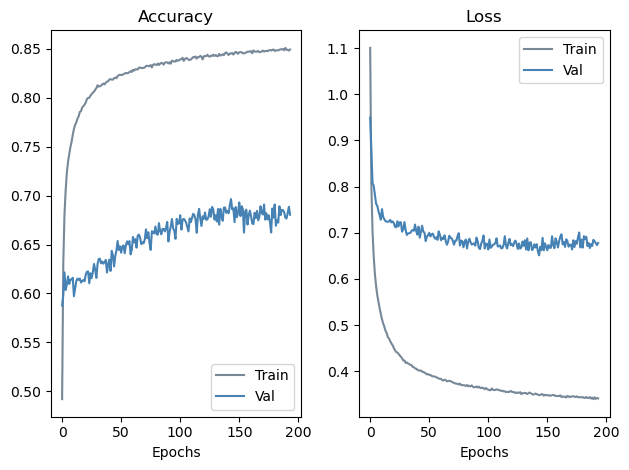

In [207]:
# Create accuracy/loss plots
def plot_history(history):
    epochs = range(len(history["loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs,  history["accuracy"], color = "lightslategrey",  label = "Train")
    plt.plot(epochs,  history["val_accuracy"], color = "steelblue", label = "Val")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs,  history["loss"], color = "lightslategrey", label = "Train")
    plt.plot(epochs,  history["val_loss"], color = "steelblue", label = "Val")
    plt.legend(loc="upper right")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.tight_layout()

    plt.savefig("model_performance.svg",format = "svg")

    plt.show()

plot_history(history)

In [208]:
# Understand the accuracies for individual training classes
y_pred_prob = model.predict([X_resampled, X_resampled])
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = np.unique(y_resampled)
per_class_accuracy = {}

# Calculate accuracy for each class
for cls in class_labels:
    idx = np.where(y_val == cls)[0]
    class_accuracy = accuracy_score(y_resampled[idx], y_pred[idx])
    per_class_accuracy[cls] = class_accuracy


for cls, acc in per_class_accuracy.items():
    print(f'Class {cls} accuracy: {acc:.2f}')

  89/2868 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

c:\Users\ameli\Anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_59. Received: the structure of inputs=('*', '*')
  warnings.warn(


2868/2868 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Class 0.0 accuracy: 0.72
Class 1.0 accuracy: 0.66
Class 2.0 accuracy: 0.69
Class 3.0 accuracy: 1.00


In [209]:
# Understand the accuracies for individual validation classes
y_pred_prob = model.predict([X_val_ct, X_val_ct])
y_pred = np.argmax(y_pred_prob, axis=1)

class_labels = np.unique(y_val)
per_class_accuracy = {}

# Calculate accuracy for each class
for cls in class_labels:
    idx = np.where(y_val == cls)[0]
    class_accuracy = accuracy_score(y_val[idx], y_pred[idx])
    per_class_accuracy[cls] = class_accuracy


for cls, acc in per_class_accuracy.items():
    print(f'Class {cls} accuracy: {acc:.2f}')

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Class 0.0 accuracy: 0.71
Class 1.0 accuracy: 0.45
Class 2.0 accuracy: 0.08
Class 3.0 accuracy: 0.00


#### Predicting Using this Model

In [210]:
# Make predictions using the sequential neural network
predict = model.predict(sample_inputs)
pred_unique_cond = np.argmax(predict, axis = 1)
print(pred_unique_cond)

309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[1 0 1 ... 0 0 0]


In [211]:
# Insert these predictions into a new column "num_unique_conditions" in the original csv
sample_data["num_unique_conditions"] = pred_unique_cond
sample_data.head()

,Unnamed: 0,nb_postcode,exposure_id,pet_gender,pet_de_sexed,pet_de_sexed_age,pet_is_switcher,pet_age_months,nb_contribution,nb_excess,...,binned_breeds,nb_contribution_FACTOR,nb_excess_FACTOR,electoraterating_grouped,breed_type_band,claim_preds,breed_severity_band,national_parks_sev_band,median_income_band_sev,num_unique_conditions
0,1,810,exposure_9d3ffbf9-9ee9-4b17-bb21-05d94d8adec2,male,False,NaN,FALSE,5,90,100,...,1,90,100,Inner/Unknown,purebred,0.177595,High Severity,0-5%,6-Jul,1
1,2,810,exposure_0625abbb-ccf4-4d37-95ed-55dcbfc39eed,male,False,NaN,Unknown,3,80,0,...,1,80,0,Inner/Unknown,purebred,0.227971,Unknown,0-5%,6-Jul,0
2,3,810,exposure_5587ecbf-7f25-4b84-87a6-6eb567d99e7e,male,True,7-12 months,FALSE,30,80,200,...,2+,80,200,Inner/Unknown,all_else,0.025166,Moderate Severity,0-5%,6-Jul,1
3,4,810,exposure_50f61c00-0524-445c-9d21-8db0047aba27,male,False,NaN,FALSE,15,80,200,...,1,80,200,Inner/Unknown,purebred,0.016295,Moderate Severity,0-5%,6-Jul,0
4,5,810,exposure_d2dfb08e-e29b-4f00-9452-0b3f4473ec28,male,True,Not Sure,Unknown,13,80,0,...,1,80,0,Inner/Unknown,all_else,0.085378,Unknown,0-5%,6-Jul,0


In [212]:
# Generate the final csv
sample_data.to_csv("sample_data_AQ.csv", index = False)

#### Computing Saliencies
Trying to understand key variables over a sample of predictions.

In [213]:
# Create a function that computes saliencies
def saliency_comp(input):
    input = np.expand_dims(input, axis=0)
    input = tf.convert_to_tensor(input, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input)
        grad_pred = model(input)

        class_index = tf.argmax(grad_pred, axis=1)[0]
        grad_output = grad_pred[0, class_index]  
    

    grads = tape.gradient(grad_output, input)
    if grads is None or tf.reduce_any(tf.math.is_nan(grads)):
        print("Gradients contain NaN values.")
        return np.zeros(input.shape[1:])  

    saliency = tf.abs(grads).numpy().squeeze()
    
    # Normalize the saliency map
    saliency -= saliency.min()
    if saliency.max() > 0: 
        saliency /= saliency.max()
    
    return saliency


In [214]:
# Calculate saliency maps for all samples
saliency_maps = []
for x in sample_inputs:
    saliency_map = saliency_comp(x) 
    saliency_maps.append(saliency_map)

# Convert list to numpy array and calculate the mean across samples
average_saliency_map = np.mean(np.stack(saliency_maps), axis=0)

In [215]:
# Confirm the saliency map has no strange values
average_saliency_map

array([0.4741748 , 0.4997795 , 0.22645664, 0.6617045 , 0.08662834,
       0.10556976, 0.18919021, 0.2868799 , 0.18929256, 0.1515457 ,
       0.51131964, 0.27232057, 0.5238619 , 0.605252  , 0.23150986,
       0.24923742, 0.10994439, 0.13157187, 0.17652002, 0.22219823,
       0.19006132, 0.15451711, 0.15816762, 0.2884097 ], dtype=float32)

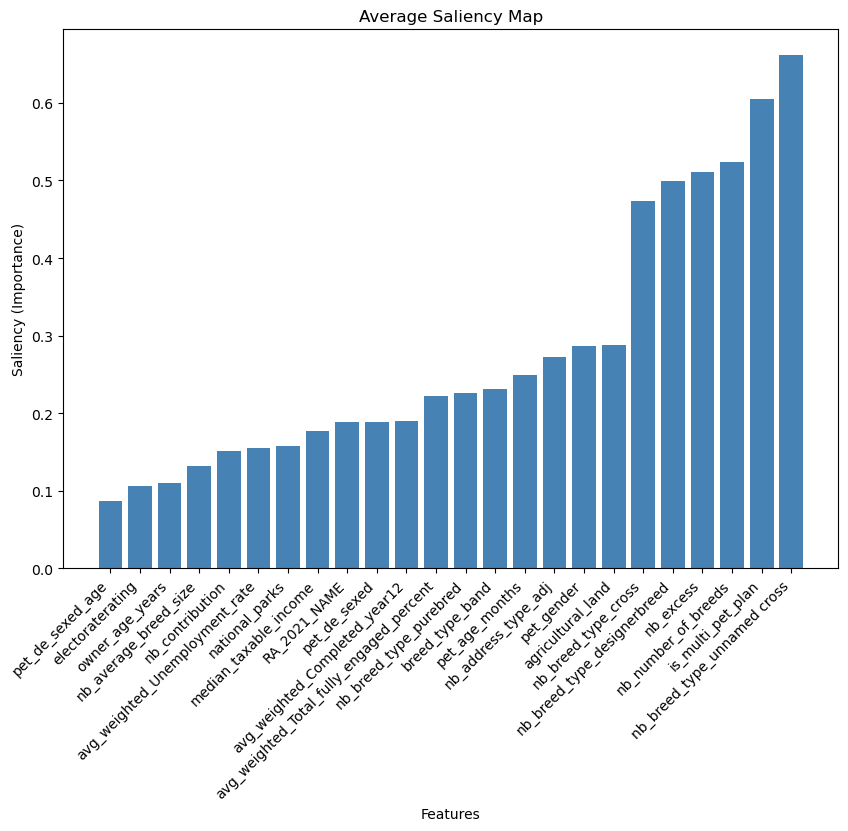

In [216]:
# Plot Average Saliency Map
variable_names = ct.get_feature_names_out()
sorted_indices = np.argsort(average_saliency_map)

# Reorder the saliency values and feature names so they increase
sorted_saliency = average_saliency_map[sorted_indices]
sorted_variable_names = [variable_names[i] for i in sorted_indices]

# Plot the sorted saliency map
plt.figure(figsize = (10, 7))
plt.bar(range(len(sorted_saliency)), sorted_saliency, tick_label = sorted_variable_names,
        color = "steelblue")
plt.xticks(rotation = 45, ha = "right") 
plt.title('Average Saliency Map')
plt.xlabel('Features')
plt.ylabel('Saliency (Importance)')

# Save the plot as an SVG file
plt.savefig("avg_saliency_map.svg", format = "svg", bbox_inches = "tight")

# Display the plot
plt.show()

## 5. Wide and Deep Neural Network
Also attempted a wide and deep neural network - have left for comparison.

#### Initialising
Setting up a random seed for reproducibility and defining the classes in target variable.

In [217]:
# Setting random seed
seed = 199

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [218]:
# Define the number of classes
num_classes = len(oe.categories_[0])
num_classes

4

In [219]:
# Wide Neural Network
input_wide = Input(shape=(X_resampled.shape[1],))
wide = Dense(num_classes, activation ='softmax',
             kernel_initializer = tf.keras.initializers.HeNormal(seed = 199))(input_wide)

# Deep Neural Network
input_deep = Input(shape=(X_resampled.shape[1],))
dense_1 = Dense(60, activation ='leaky_relu',
                kernel_initializer = tf.keras.initializers.HeNormal(seed = 199))(input_deep)
dense_2 = Dense(30, activation ='leaky_relu',
                kernel_initializer = tf.keras.initializers.HeNormal(seed = 199))(dense_1)
deep = Dense(num_classes, activation ='softmax',
             kernel_initializer = tf.keras.initializers.HeNormal(seed = 199))(dense_2)  

# Combine wide and deep parts
combined = concatenate([wide, deep])
output = Dense(num_classes, activation ='softmax',
               kernel_initializer = tf.keras.initializers.HeNormal(seed = 199))(combined)  

# Create and compile the model
model = Model(inputs = [input_wide, input_deep], outputs = output)
model.compile(optimizer = Adam(0.0001), loss = "sparse_categorical_crossentropy", 
              metrics = ['accuracy'])                         

es = EarlyStopping(patience = 100, restore_best_weights = True,
    monitor = "val_accuracy", verbose=1)

hist_es = model.fit([X_resampled, X_resampled], y_resampled, epochs = 1_000, 
                    validation_data = ([X_val_ct, X_val_ct], y_val), 
                    callbacks = [es], verbose = False, batch_size = 512);
history = hist_es.history

print(f"Stopped after {len(hist_es.history['loss'])} epochs.")

c:\Users\ameli\Anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70', 'keras_tensor_72']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 47.
Stopped after 147 epochs.


In [220]:
loss, accuracy = model.evaluate([X_val_ct, X_val_ct], y_val)
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Loss: {loss}")

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5673 - loss: 1.0308
Validation Accuracy: 0.566189169883728
Validation Loss: 1.0258961915969849


In [221]:
loss, accuracy = model.evaluate([X_test_ct, X_test_ct], y_test)
print(f"Test Accuracy: {accuracy}")
print(f"Test Loss: {loss}")

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5725 - loss: 1.0104
Test Accuracy: 0.5657488703727722
Test Loss: 1.0165510177612305


In [222]:
# Find the F1 score on the validation set
y_pred = model.predict([X_val_ct, X_val_ct])
y_pred = np.argmax(y_pred, axis = 1)
f1_score(y_val, y_pred, average = 'weighted')

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.6956835980912097

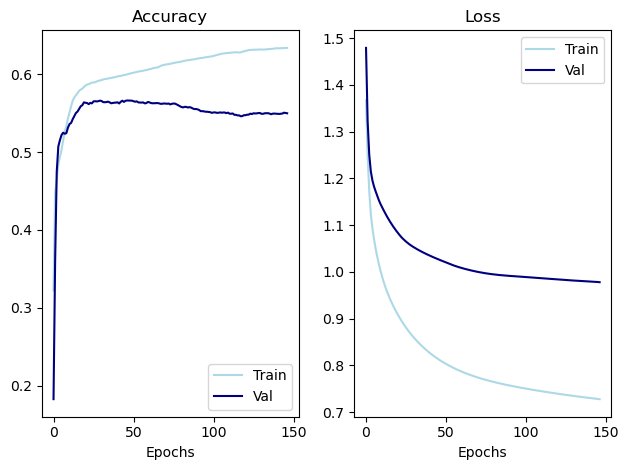

In [223]:
# Plot accuracy/loss curves
def plot_history(history):
    epochs = range(len(history["loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs,  history["accuracy"], color = "lightblue",  label="Train")
    plt.plot(epochs,  history["val_accuracy"], color = "navy", label="Val")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs,  history["loss"], color = "lightblue", label="Train")
    plt.plot(epochs,  history["val_loss"], color = "navy", label="Val")
    plt.legend(loc="upper right")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.tight_layout()

    plt.show()

plot_history(history)